In [1]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 
import glob

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns
import datetime

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from pathlib import Path

In [2]:

# Function to identify peaks and troughs
#neds to be modified to filter peaks when signal is bad
def identify_peaks_and_troughs(data, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    data = data.dropna()
    data = data[~data.index.duplicated(keep='first')]
    data = data.sort_index()
    data_values = data.values.squeeze()
    peaks, _ = find_peaks(data_values, width=width_peaks, prominence=prominence_peaks)
    troughs, _ = find_peaks(-data_values, width=width_troughs, prominence=prominence_troughs)
    troughs = troughs[troughs > peaks[0]]
    peak_times = data.index[peaks]
    trough_times = data.index[troughs]
    return peak_times, trough_times


In [3]:

# Function to align sniff peaks with rewards
def align_sniff_peaks_with_rewards(stream_data, reward_sites, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    sniff_aligned = reward_sites.copy()
    peak_times, trough_times = identify_peaks_and_troughs(stream_data.breathing, width_peaks, prominence_peaks, width_troughs, prominence_troughs)
    first_peaks = [np.searchsorted(peak_times, start_time) for start_time in sniff_aligned.index]
    first_sniff_peak_start_time = [peak_times[fp] for fp in first_peaks]
    sniff_aligned['first_sniff_peak'] = first_sniff_peak_start_time
    sniff_aligned = sniff_aligned.set_index('first_sniff_peak')
    sniff_aligned.index.name = 'times'
    return sniff_aligned

In [4]:
mouse = '745306'
# Define the path to the mouse folder
mouse_folder_path = Path(f'/Volumes/aind/scratch/vr-foraging/data/{mouse}')

# Function to process a single session and return peaks_df
def process_session(session_path):
    # Extract mouse_id from the first 6 numbers in the file name
    mouse = session_path.name[:6]
    # Extract session from the first 8 numbers after mouse_id
    session = session_path.name[6:14]
    try:

        data = parse.load_session_data(session_path)
        reward_sites, active_site, config = parse.parse_dataframe(data)
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()
        color_dict_label = {}
        dict_odor = {}
        list_patches = parse.TaskSchemaProperties(data).patches
        for i, patches in enumerate(list_patches):
            color_dict_label[patches['label']] = odor_list_color[i]
            dict_odor[i] = patches['label']
        stream_data = parse.ContinuousData(data)
        encoder_data = stream_data.encoder_data

        active_site['next_intersite'] = active_site.index.to_series().shift(-1)
        reward_sites = active_site.loc[active_site['label'] == 'RewardSite']
        reward_sites['time_in_odor_site'] = reward_sites.next_intersite - reward_sites.index
        plot_df = reward_sites[['time_in_odor_site', 'odor_label', 'active_patch']]
        label_dict = {**{
            "InterSite": '#808080',
            "InterPatch": '#b3b3b3'}, **color_dict_label}
        sniff_aligned = align_sniff_peaks_with_rewards(stream_data, reward_sites)
        trial_summary_breathing = plotting.trial_collection(
            sniff_aligned[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], 
            stream_data.breathing, 
            mouse, 
            session, 
            window=(-2, 8), 
            taken_col='data'
        )
        
        peaks_data = []
        for odor_label in trial_summary_breathing['odor_label'].unique():
            odor_df = trial_summary_breathing[trial_summary_breathing['odor_label'] == odor_label]
            for site in odor_df['odor_sites'].unique():
                site_df = odor_df[odor_df['odor_sites'] == site]
                signal = site_df.set_index('times')['data']
                odor_end_time = odor_df['time_in_odor_site'].unique()[0]
                x_start = 0
                x_end = odor_end_time
                filtered_signal = signal[(signal.index >= x_start) & (signal.index <= x_end)]
                if filtered_signal.empty:
                    continue
                peak_times, _ = find_peaks(filtered_signal, width=5, prominence=0.1)
                if len(peak_times) > 0:
                    peak_times_indices = filtered_signal.index[peak_times]
                    peak_count = len(peak_times_indices)
                    epoch_duration = x_end - x_start
                    peak_frequency = peak_count / epoch_duration if epoch_duration > 0 else 0
                    peaks_data.append({
                        'session': session_path.name,
                        'odor_label': odor_label, 
                        'odor_site': site, 
                        'peak_count': peak_count,
                        'peak_frequency': peak_frequency,
                        'epoch_duration': epoch_duration
                    })
                    peak_count_after_1s = sum(peak <= 1 for peak in peak_times_indices)
                    peaks_data[-1]['peak_count_after_1s'] = peak_count_after_1s

        return pd.DataFrame(peaks_data)
    except Exception as e:
        print(f"Error processing session {session_path.name}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

# Iterate through all sessions and aggregate results
all_peaks_data = []
for session_dir in os.listdir(mouse_folder_path):
    session_path = mouse_folder_path / session_dir
    if session_path.is_dir():
        session_peaks_df = process_session(session_path)
        if not session_peaks_df.empty:
            all_peaks_data.append(session_peaks_df)

# concatenate all session data into a single DataFrame
if all_peaks_data:
    summary_peaks_df = pd.concat(all_peaks_data, ignore_index=True)
else:
    summary_peaks_df = pd.DataFrame()  # Handle the case where no data was processed

# Print the summary DataFrame
print(summary_peaks_df)


Error processing session 745306_20240723T171624: 'odor_label'
                    session odor_label  odor_site  peak_count  peak_frequency  \
0    745306_20240724T103330       NULL        0.0          49        4.158181   
1    745306_20240724T103330       NULL        1.0          48        4.073320   
2    745306_20240724T103330       NULL        2.0          35        2.970129   
3    745306_20240724T103330       NULL        3.0          40        3.394433   
4    745306_20240724T103330       NULL        4.0          44        3.733876   
..                      ...        ...        ...         ...             ...   
412  745306_20240803T131459     ODOR_C       32.0          25        8.286399   
413  745306_20240803T131459     ODOR_C       34.0          20        6.629119   
414  745306_20240803T131459     ODOR_C       41.0          24        7.954943   
415  745306_20240803T131459     ODOR_C       61.0          23        7.623487   
416  745306_20240803T131459     ODOR_C       79

In [61]:
#save df to csv in /Users/nehal.ajmal/Documents/aindproject/results
summary_peaks_df.to_csv(f'/Users/nehal.ajmal/Documents/aindproject/results/{mouse}_peaks_data.csv', index=False)

In [71]:
#read csv
summary_peaks_df = pd.read_csv(f'/Users/nehal.ajmal/Documents/aindproject/results/{mouse}_peaks_data.csv')

#replace Nan with NULL label
summary_peaks_df['odor_label'] = summary_peaks_df['odor_label'].replace(np.nan, 'NULL')

summary_peaks_df

# Group by 'session' and get unique 'odor_label'
unique_odor_labels_per_session = summary_peaks_df.groupby('session')['odor_label'].unique().reset_index()


In [72]:
# Group by 'session' and get unique 'odor_label'
unique_odor_labels_per_session = summary_peaks_df.groupby('session')['odor_label'].unique().reset_index()

print(unique_odor_labels_per_session)

                   session                      odor_label
0   745306_20240724T103330                          [NULL]
1   745306_20240725T102446                          [NULL]
2   745306_20240725T163307                          [NULL]
3   745306_20240726T101359                          [NULL]
4   745306_20240726T170153                          [NULL]
5   745306_20240729T093351                          [NULL]
6   745306_20240729T163208                          [NULL]
7   745306_20240730T102416                  [NULL, ODOR_A]
8   745306_20240731T100050                  [NULL, ODOR_A]
9   745306_20240801T100355          [NULL, ODOR_A, ODOR_B]
10  745306_20240802T100131  [NULL, ODOR_A, ODOR_C, ODOR_B]
11  745306_20240803T131459  [NULL, ODOR_A, ODOR_B, ODOR_C]


In [73]:
# Dictionary mapping each session to a session_type
session_type_mapping = {
    '745306_20240729T163208': 'session_0',
    '7745306_20240730T102416': 'session_1',
    '745306_20240731T100050': 'session_2',
    '745306_20240801T100355': 'session_3',
    '745306_20240802T100131': 'session_4',
    '745306_20240803T131459' : 'session_5'

}

# Map the dictionary to create a new column
summary_peaks_df['session_type'] = summary_peaks_df['session'].map(session_type_mapping)


In [76]:

#remove all rows with session_type NaN values, but keep NULL
summary_peaks_df = summary_peaks_df.dropna(subset=['session_type'])


In [86]:
#for each session type, get the first 10 odor sites of each odor label present in the session. if less than 10, get all odor sites
#store in a new dataframe
summary_peaks_df_first_10 = pd.DataFrame()
for session_type in summary_peaks_df['session_type'].unique():
    session_type_df = summary_peaks_df[summary_peaks_df['session_type'] == session_type]
    for odor_label in session_type_df['odor_label'].unique():
        odor_label_df = session_type_df[session_type_df['odor_label'] == odor_label]
        first_10_odor_sites = odor_label_df.head(10)
        summary_peaks_df_first_10 = pd.concat([summary_peaks_df_first_10, first_10_odor_sites])

summary_peaks_df_first_10_745306 = summary_peaks_df_first_10

#save df to csv in /Users/nehal.ajmal/Documents/aindproject/results2
summary_peaks_df_first_10.to_csv(f'/Users/nehal.ajmal/Documents/aindproject/results2/{mouse}_peaks_data_first_10.csv', index=False)


In [129]:
mouse = '717717'

#read csv
summary_peaks_df = pd.read_csv(f'/Users/nehal.ajmal/Documents/aindproject/results/{mouse}_peaks_data.csv')

#replace Nan with NULL label
summary_peaks_df['odor_label'] = summary_peaks_df['odor_label'].replace(np.nan, 'NULL')

# Group by 'session' and get unique 'odor_label'
unique_odor_labels_per_session = summary_peaks_df.groupby('session')['odor_label'].unique().reset_index()

# Group by 'session' and get unique 'odor_label'
unique_odor_labels_per_session = summary_peaks_df.groupby('session')['odor_label'].unique().reset_index()
unique_odor_labels_per_session


,session,odor_label
0,717717_20240723T161400,[NULL]
1,717717_20240724T095017,[NULL]
2,717717_20240725T085436,[NULL]
3,717717_20240725T154240,[NULL]
4,717717_20240726T091519,[NULL]
5,717717_20240726T163154,[NULL]
6,717717_20240729T083248,[NULL]
7,717717_20240729T152817,[NULL]
8,717717_20240730T092311,"[NULL, ODOR_A]"
9,717717_20240731T090814,"[NULL, ODOR_A]"


In [130]:
# Dictionary mapping each session to a session_type
session_type_mapping = {
    '717717_20240729T152817': 'session_0',
    '717717_20240730T092311': 'session_1',
    '717717_20240731T090814': 'session_2',
    '717717_20240801T091148	': 'session_3',
    '717717_20240802T091009': 'session_4',
    '717717_20240803T114516' :'session_5'
}

In [131]:
# Map the dictionary to create a new column
summary_peaks_df['session_type'] = summary_peaks_df['session'].map(session_type_mapping)

# Remove all rows with session_type NaN values, but keep NULL (0)
summary_peaks_df = summary_peaks_df.dropna(subset=['session_type'])

# Store in a new dataframe
summary_peaks_df_first_10 = pd.DataFrame()
for session_type in summary_peaks_df['session_type'].unique():
    session_type_df = summary_peaks_df[summary_peaks_df['session_type'] == session_type]
    for odor_label in session_type_df['odor_label'].unique():
        odor_label_df = session_type_df[session_type_df['odor_label'] == odor_label]
        first_10_odor_sites = odor_label_df.head(10)
        summary_peaks_df_first_10 = pd.concat([summary_peaks_df_first_10, first_10_odor_sites])

summary_peaks_df_first_10_717717 = summary_peaks_df_first_10
summary_peaks_df_first_10_717717

,session,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,session_type
856,717717_20240729T152817,NULL,0.0,16,9.685230,1.652000,9,session_0
857,717717_20240729T152817,NULL,1.0,16,9.685230,1.652000,9,session_0
858,717717_20240729T152817,NULL,2.0,17,10.290557,1.652000,10,session_0
859,717717_20240729T152817,NULL,3.0,14,8.474576,1.652000,8,session_0
860,717717_20240729T152817,NULL,4.0,14,8.474576,1.652000,8,session_0
...,...,...,...,...,...,...,...,...
1527,717717_20240803T114516,ODOR_B,62.0,12,7.421187,1.616992,7,session_5
1528,717717_20240803T114516,ODOR_B,77.0,13,8.039619,1.616992,7,session_5
1529,717717_20240803T114516,ODOR_B,90.0,11,6.802755,1.616992,6,session_5
1530,717717_20240803T114516,ODOR_B,94.0,12,7.421187,1.616992,7,session_5


In [132]:

#save df to csv in /Users/nehal.ajmal/Documents/aindproject/results2
summary_peaks_df_first_10.to_csv(f'/Users/nehal.ajmal/Documents/aindproject/results2/{mouse}_peaks_data_first_10.csv', index=False)


In [150]:
#load in all the csvs in /Users/nehal.ajmal/Documents/aindproject/results2
all_files = glob.glob('/Users/nehal.ajmal/Documents/aindproject/results2/*.csv')


#make each csv into a dataframe and concatenate them
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

#make a column for mouse_id
frame['mouse_id'] = frame['session'].str[:6]

#replace Nan with NULL label
frame['odor_label'] = frame['odor_label'].replace(np.nan, 'NULL')


In [164]:
#remove all epoch_duration values that are over 15s
frame = frame[frame['epoch_duration'] <= 15]
frame

#save df to csv in /Users/nehal.ajmal/Documents/aindproject/results2
frame.to_csv(f'/Users/nehal.ajmal/Documents/aindproject/results2/all_peaks_data_first_10.csv', index=False)


#load in the csv
frame = pd.read_csv(f'/Users/nehal.ajmal/Documents/aindproject/results2/all_peaks_data_first_10.csv')
frame

,session,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,session_type,mouse_id
0,745300_20240731T091738,NaN,0.0,31,8.066598,3.843008,7,session_1,745300
1,745300_20240731T091738,NaN,2.0,30,7.806385,3.843008,7,session_1,745300
2,745300_20240731T091738,NaN,4.0,18,4.683831,3.843008,6,session_1,745300
3,745300_20240731T091738,NaN,5.0,20,5.204257,3.843008,6,session_1,745300
4,745300_20240731T091738,NaN,6.0,12,3.122554,3.843008,5,session_1,745300
...,...,...,...,...,...,...,...,...,...
753,717716_20240803T105420,ODOR_C,46.0,12,7.782020,1.542016,8,session_5,717716
754,717716_20240803T105420,ODOR_C,51.0,11,7.133519,1.542016,7,session_5,717716
755,717716_20240803T105420,ODOR_C,65.0,11,7.133519,1.542016,7,session_5,717716
756,717716_20240803T105420,ODOR_C,77.0,12,7.782020,1.542016,8,session_5,717716


In [167]:
# Filter data for sessions 2 and 4
sessions_of_interest = ['session_2', 'session_4']
filtered_df = frame[frame['session_type'].isin(sessions_of_interest)]

# Sort data by session_type, mouse_id, odor_label, and odor_site, then take the first 10 trials for each odor in each session and mouse
sorted_df = filtered_df.sort_values(by=['session_type', 'mouse_id', 'odor_label', 'odor_site'])
first_10_trials_df = sorted_df.groupby(['session_type', 'mouse_id', 'odor_label']).head(10)

print(first_10_trials_df)


                    session odor_label  odor_site  peak_count  peak_frequency  \
644  717716_20240731T081436     ODOR_A        1.0           8        7.797149   
645  717716_20240731T081436     ODOR_A        3.0           8        7.797149   
646  717716_20240731T081436     ODOR_A        4.0           7        6.822506   
647  717716_20240731T081436     ODOR_A        6.0           7        6.822506   
648  717716_20240731T081436     ODOR_A        7.0           9        8.771793   
..                      ...        ...        ...         ...             ...   
558  745306_20240802T100131     ODOR_C       37.0          40        4.469777   
559  745306_20240802T100131     ODOR_C       39.0          42        4.693266   
560  745306_20240802T100131     ODOR_C       52.0          51        5.698966   
561  745306_20240802T100131     ODOR_C       67.0          50        5.587221   
562  745306_20240802T100131     ODOR_C       81.0          45        5.028499   

     epoch_duration  peak_c

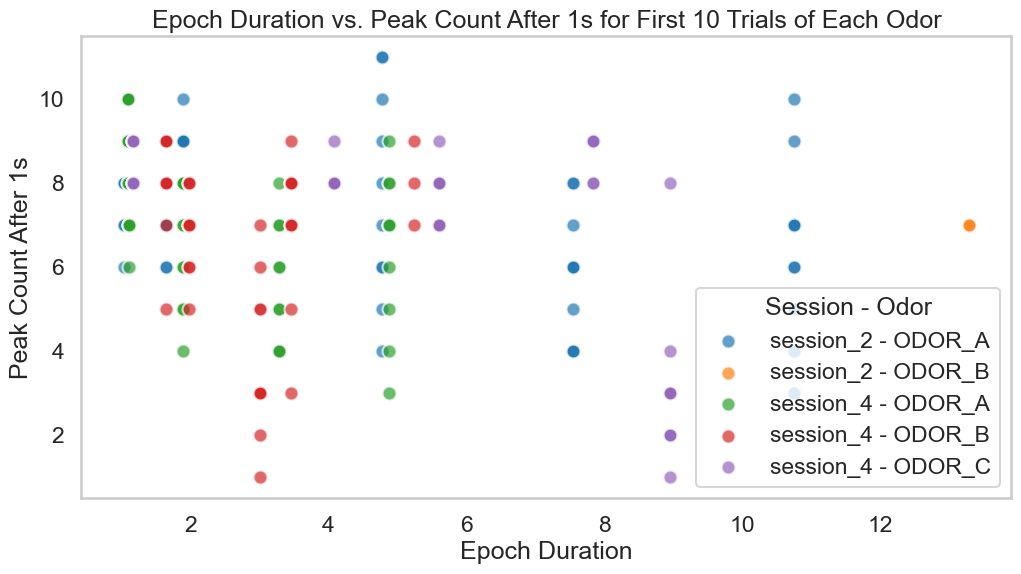

In [169]:

# Plotting
plt.figure(figsize=(12, 6))

for (session, odor), group in first_10_trials_df.groupby(['session_type', 'odor_label']):
    plt.scatter(group['epoch_duration'], group['peak_count_after_1s'], 
                label=f"{session} - {odor}", 
                alpha=0.7, 
                edgecolors='w', 
                s=100)  # Customize marker size if needed

plt.xlabel('Epoch Duration')
plt.ylabel('Peak Count After 1s')
plt.title('Epoch Duration vs. Peak Count After 1s for First 10 Trials of Each Odor')
plt.legend(title='Session - Odor')
plt.grid(False)
plt.show()


In [172]:
#load in csv  /Users/nehal.ajmal/Downloads/merged_filtered_df.csv
marinaframe = pd.read_csv('/Users/nehal.ajmal/Downloads/merged_filtered_df.csv')

marinaframe

,Unnamed: 0,full_session_name,odor_label,odor_site,peak_count,peak_frequency,epoch_duration,peak_count_after_1s,mouse,session,...,previous_interpatch,previous_intersite,same_patch,time_in_site,session_n,session_type,time_in_session,I don,experimental_round,max_session_n_session_0
0,0,717717_20240730T092311,NO ODOR,0,16,9.791826,1.634016,9,717717,20240730,...,10252702.19,10252711.00,0.0,1.634016,9,session_1,9.907008,2.209688,1,NaN
1,1,717717_20240730T092311,NO ODOR,1,16,9.791826,1.634016,10,717717,20240730,...,10252715.73,10252725.95,1.0,1.753984,9,session_1,25.282016,6.621502,1,NaN
2,2,717717_20240730T092311,NO ODOR,2,13,7.955858,1.634016,8,717717,20240730,...,10252730.52,10252733.38,1.0,1.533984,9,session_1,32.841024,8.559393,1,NaN
3,3,717717_20240730T092311,NO ODOR,3,14,8.567848,1.634016,9,717717,20240730,...,10252737.26,10252740.15,1.0,3.434016,9,session_1,39.407008,10.254451,1,NaN
4,4,717717_20240730T092311,NO ODOR,4,14,8.567848,1.634016,8,717717,20240730,...,10252747.02,10252755.30,1.0,1.960000,9,session_1,56.249024,13.165516,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,2733,745301_20240803T123112,ODOR_C,58,16,7.011443,2.281984,6,745301,20240803,...,10610391.40,10610397.19,0.0,1.726016,12,session_5,810.532000,151.894478,1,NaN
1109,2734,745301_20240803T123112,ODOR_C,73,16,7.011443,2.281984,7,745301,20240803,...,10610576.33,10610604.38,0.0,1.996000,12,session_5,1017.587008,187.895318,1,NaN
1110,2735,745301_20240803T123112,ODOR_C,76,14,6.135012,2.281984,5,745301,20240803,...,10610634.01,10610643.68,0.0,1.852000,12,session_5,1058.599008,197.245844,1,NaN
1111,2736,745301_20240803T123112,ODOR_C,84,17,7.449658,2.281984,7,745301,20240803,...,10610766.48,10610782.01,0.0,2.275008,12,session_5,1195.642016,220.597518,1,NaN


In [173]:
# Filter data for sessions 2 and 4
sessions_of_interest = ['session_2', 'session_4']
filtered_df = marinaframe[marinaframe['session_type'].isin(sessions_of_interest)]

# Sort data by session_type, mouse_id, odor_label, and odor_site, then take the first 10 trials for each odor in each session and mouse
sorted_df = filtered_df.sort_values(by=['session_type', 'mouse', 'odor_label', 'odor_site'])
first_10_trials_df = sorted_df.groupby(['session_type', 'mouse', 'odor_label']).head(10)

print(first_10_trials_df)


     Unnamed: 0       full_session_name odor_label  odor_site  peak_count  \
447        1601  717716_20240731T081436    NO ODOR          0           9   
448        1602  717716_20240731T081436    NO ODOR          2           8   
449        1603  717716_20240731T081436    NO ODOR          5           7   
450        1604  717716_20240731T081436    NO ODOR          9           8   
451        1605  717716_20240731T081436    NO ODOR         10           7   
..          ...                     ...        ...        ...         ...   
867        2271  745306_20240802T100131     ODOR_C         37          40   
868        2272  745306_20240802T100131     ODOR_C         39          42   
869        2273  745306_20240802T100131     ODOR_C         52          51   
870        2274  745306_20240802T100131     ODOR_C         67          50   
871        2275  745306_20240802T100131     ODOR_C         81          45   

     peak_frequency  epoch_duration  peak_count_after_1s   mouse   session 

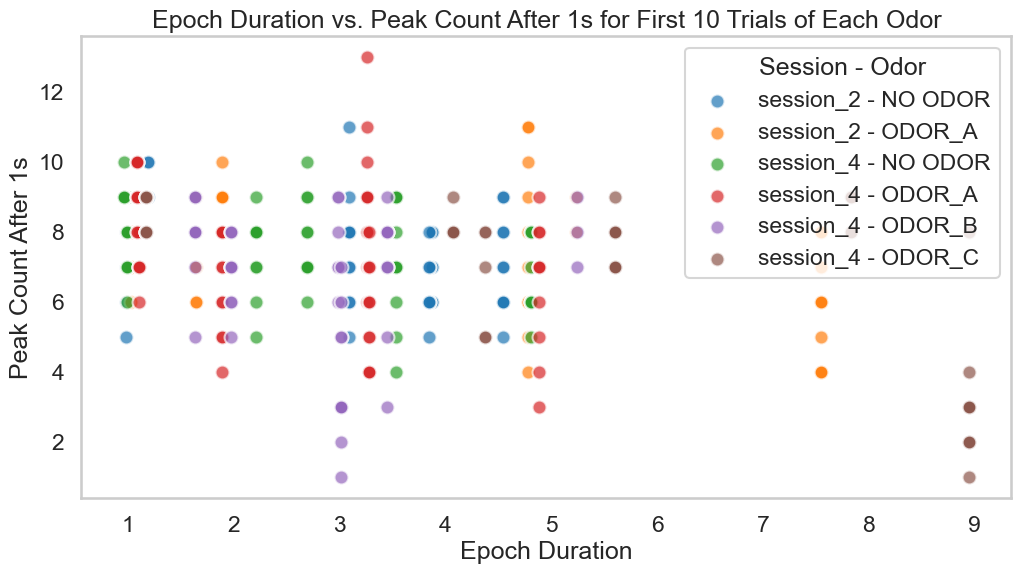

In [174]:
# Plotting
plt.figure(figsize=(12, 6))

for (session, odor), group in first_10_trials_df.groupby(['session_type', 'odor_label']):
    plt.scatter(group['epoch_duration'], group['peak_count_after_1s'], 
                label=f"{session} - {odor}", 
                alpha=0.7, 
                edgecolors='w', 
                s=100)  # Customize marker size if needed

plt.xlabel('Epoch Duration')
plt.ylabel('Peak Count After 1s')
plt.title('Epoch Duration vs. Peak Count After 1s for First 10 Trials of Each Odor')
plt.legend(title='Session - Odor')
plt.grid(False)
plt.show()
